In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../../ragali/')

import get_datasets

In [4]:
import xarray as xr

# Dev find adjacent CML-gauge pairs

In [352]:
ds_cml = xr.open_dataset('../data/openMRG_example.nc')
ds_gauge = xr.open_dataset('../data/openMRG_city_gauges_20150827.nc')

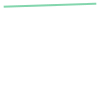

In [353]:
from shapely import LineString, Point


cml_lines = []
for cml_id in ds_cml.cml_id.values:
    cml = ds_cml.sel(cml_id=cml_id)

    line = LineString([(cml.site_0_lon, cml.site_0_lat), (cml.site_1_lon, cml.site_1_lat)])
    cml_lines.append(line)

line = cml_lines[137]
line

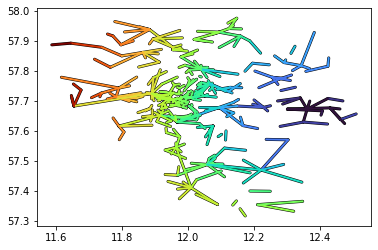

In [354]:
d = line.distance(cml_lines)

ds_cml['foo'] = ('cml_id', d)

import plot_map
plot_map.scatter_line(ds_cml.foo, cmap='turbo');

In [355]:
ds_gauge



<xarray.Dataset>
Dimensions:          (time: 1440, station_id: 10)
Coordinates:
  * station_id       (station_id) object 'Jarn' 'Torp' ... 'Lbom' 'Askim'
  * time             (time) datetime64[ns] 2015-08-27 ... 2015-08-27T23:59:00
    lon              (station_id) float64 ...
    lat              (station_id) float64 ...
    location         (station_id) object ...
    type             (station_id) object ...
    quantization     (station_id) float64 ...
Data variables:
    rainfall_amount  (time, station_id) float64 ...

In [358]:
points = []
for gauge_id in ds_gauge.station_id.values:
    gauge = ds_gauge.sel(station_id=gauge_id)
    points.append(Point([gauge.lon, gauge.lat]))

In [360]:
line = cml_lines[0]
line.distance(points)

array([0.07057734, 0.04316719, 0.09149708, 0.2062587 , 0.01786174,
       0.08600831, 0.05352927, 0.00307827, 0.02935414, 0.08079134])

In [361]:
ds_gauge.station_id.values

array(['Jarn', 'Torp', 'Bergsj', 'Torsl', 'Chalm', 'Tole', 'Barl',
       'Drakeg', 'Lbom', 'Askim'], dtype=object)

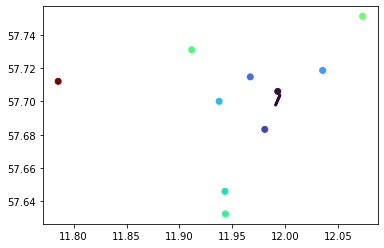

In [362]:
i = 0

plot_map.scatter_line(ds_cml.rsl.isel(cml_id=i).isel(time=0), vmin=0, vmax=1)

import matplotlib.pyplot as plt

line = cml_lines[i]
plt.scatter(ds_gauge.lon, ds_gauge.lat, c=line.distance(points), cmap='turbo')

In [410]:
def _shapely_lines_from_dataset(ds_cmls):
    lines = [
        LineString([
            (ds_cml.isel(cml_id=i).site_0_lon, ds_cml.isel(cml_id=i).site_0_lat),
            (ds_cml.isel(cml_id=i).site_1_lon, ds_cml.isel(cml_id=i).site_1_lat)
        ]) for i in range(len(ds_cmls.cml_id.values))
    ]
    return lines


def _shapely_points_from_dataset(ds_gauges):
    points = [
        Point([ds_gauges.isel(station_id=i).lon, ds_gauges.isel(station_id=i).lat])
        for i in range(len(ds_gauges.station_id.values))
    ]
    return points


def get_gauge_distance_per_cml(ds_cmls, ds_gauges):
    lines = _shapely_lines_from_dataset(ds_cmls)
    points = _shapely_points_from_dataset(ds_gauges)
    gauge_distance_per_cml_line = xr.DataArray(
        data=[line.distance(points) for line in lines],
        coords={
            'cml_id': ds_cml.cml_id,
            'station_id': ds_gauge.station_id,
        },
    )
    return gauge_distance_per_cml_line


def get_n_closest_gauges(ds_cmls, ds_gauges, n_closest=3):
    gauge_distance_per_cml = get_gauge_distance_per_cml(
        ds_cmls=ds_cmls, ds_gauges=ds_gauges,
    )
    
    closest_gauges = xr.Dataset(
        data_vars={
            'distance': (
                ('cml_id', 'n_closest'),
                np.sort(gauge_distance_per_cml, axis=1)
            ),
            'station_id': (
                ('cml_id', 'n_closest'),
                gauge_distance_per_cml.station_id.values[np.argsort(gauge_distance_per_cml)]
            ),
        },
        coords={
            'cml_id': ds_cmls.cml_id.values,
        },
    )
    return closest_gauges.isel(n_closest=slice(0, n_closest))

In [425]:
closest_gauges = get_n_closest_gauges(ds_cmls, ds_gauge, n_closest=3)

In [481]:
closest_gauges

<xarray.Dataset>
Dimensions:     (cml_id: 364, n_closest: 3)
Coordinates:
  * cml_id      (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
Dimensions without coordinates: n_closest
Data variables:
    distance    (cml_id, n_closest) float64 0.003078 0.01786 ... 0.01792 0.02884
    station_id  (cml_id, n_closest) object 'Drakeg' 'Chalm' ... 'Lbom' 'Chalm'

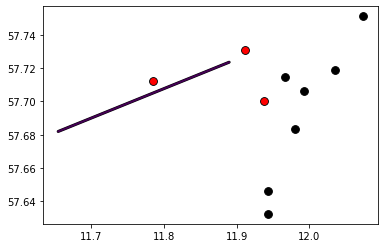

In [513]:
i = 359
i = 282

plot_map.scatter_line(
    ds_cmls.isel(cml_id=[i, ]).isel(sublink_id=0).rsl.isel(time=0), vmin=0, vmax=1,
)

ds_gauges_closest = ds_gauge.sel(station_id=closest_gauges.isel(cml_id=i).station_id.values)

ds_gauges = ds_gauge
plt.scatter(ds_gauges.lon, ds_gauges.lat, c='k', s=60);
#plt.scatter(ds_gauges_closest.lon, ds_gauges_closest.lat, c=closest_gauges.isel(cml_id=i).distance);
plt.scatter(ds_gauges_closest.lon, ds_gauges_closest.lat, c='r')

In [413]:
get_gauge_distance_per_cml(ds_cml, ds_gauge)

<xarray.DataArray (cml_id: 364, station_id: 10)>
array([[0.07057734, 0.04316719, 0.09149708, ..., 0.00307827, 0.02935414,
        0.08079134],
       [0.08225676, 0.05418746, 0.09504427, ..., 0.02240334, 0.00983541,
        0.09490069],
       [0.05626218, 0.06120292, 0.10979018, ..., 0.01809002, 0.02361975,
        0.06767365],
       ...,
       [0.17435551, 0.10915092, 0.11239935, ..., 0.13793338, 0.16517263,
        0.17447989],
       [0.02975716, 0.06341351, 0.10496934, ..., 0.06109628, 0.07931331,
        0.02394883],
       [0.07781248, 0.02915323, 0.07761342, ..., 0.00483043, 0.01792394,
        0.08935807]])
Coordinates:
  * cml_id      (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
  * station_id  (station_id) object 'Jarn' 'Torp' 'Bergsj' ... 'Lbom' 'Askim'

In [367]:
gauge_distance_per_cml = get_gauge_distance_per_cml(ds_cml, ds_gauge)
gauge_distance_per_cml

<xarray.DataArray (cml_id: 364, station_id: 10)>
array([[0.07057734, 0.04316719, 0.09149708, ..., 0.00307827, 0.02935414,
        0.08079134],
       [0.08225676, 0.05418746, 0.09504427, ..., 0.02240334, 0.00983541,
        0.09490069],
       [0.05626218, 0.06120292, 0.10979018, ..., 0.01809002, 0.02361975,
        0.06767365],
       ...,
       [0.17435551, 0.10915092, 0.11239935, ..., 0.13793338, 0.16517263,
        0.17447989],
       [0.02975716, 0.06341351, 0.10496934, ..., 0.06109628, 0.07931331,
        0.02394883],
       [0.07781248, 0.02915323, 0.07761342, ..., 0.00483043, 0.01792394,
        0.08935807]])
Coordinates:
  * cml_id      (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
  * station_id  (station_id) object 'Jarn' 'Torp' 'Bergsj' ... 'Lbom' 'Askim'

In [368]:
argsort_index = np.argsort(gauge_distance_per_cml, axis=1)
argsort_index

<xarray.DataArray (cml_id: 364, station_id: 10)>
array([[7, 4, 8, ..., 5, 2, 3],
       [8, 7, 4, ..., 9, 2, 3],
       [4, 7, 8, ..., 5, 2, 3],
       ...,
       [1, 2, 7, ..., 6, 5, 3],
       [9, 0, 4, ..., 2, 5, 3],
       [7, 8, 4, ..., 0, 9, 3]])
Coordinates:
  * cml_id      (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
  * station_id  (station_id) object 'Jarn' 'Torp' 'Bergsj' ... 'Lbom' 'Askim'

In [369]:
gauge_distance_per_cml

<xarray.DataArray (cml_id: 364, station_id: 10)>
array([[0.07057734, 0.04316719, 0.09149708, ..., 0.00307827, 0.02935414,
        0.08079134],
       [0.08225676, 0.05418746, 0.09504427, ..., 0.02240334, 0.00983541,
        0.09490069],
       [0.05626218, 0.06120292, 0.10979018, ..., 0.01809002, 0.02361975,
        0.06767365],
       ...,
       [0.17435551, 0.10915092, 0.11239935, ..., 0.13793338, 0.16517263,
        0.17447989],
       [0.02975716, 0.06341351, 0.10496934, ..., 0.06109628, 0.07931331,
        0.02394883],
       [0.07781248, 0.02915323, 0.07761342, ..., 0.00483043, 0.01792394,
        0.08935807]])
Coordinates:
  * cml_id      (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
  * station_id  (station_id) object 'Jarn' 'Torp' 'Bergsj' ... 'Lbom' 'Askim'

In [370]:
np.sort(gauge_distance_per_cml, axis=1)

array([[0.00307827, 0.01786174, 0.02935414, ..., 0.08600831, 0.09149708,
        0.2062587 ],
       [0.00983541, 0.02240334, 0.04044974, ..., 0.09490069, 0.09504427,
        0.18762799],
       [0.01065352, 0.01809002, 0.02361975, ..., 0.07404539, 0.10979018,
        0.19063814],
       ...,
       [0.10915092, 0.11239935, 0.13793338, ..., 0.18770045, 0.22244165,
        0.33857966],
       [0.02394883, 0.02975716, 0.0449442 , ..., 0.10496934, 0.11652752,
        0.20012844],
       [0.00483043, 0.01792394, 0.02884436, ..., 0.07781248, 0.08935807,
        0.19943817]])

In [371]:
np.argsort(gauge_distance_per_cml)

<xarray.DataArray (cml_id: 364, station_id: 10)>
array([[7, 4, 8, ..., 5, 2, 3],
       [8, 7, 4, ..., 9, 2, 3],
       [4, 7, 8, ..., 5, 2, 3],
       ...,
       [1, 2, 7, ..., 6, 5, 3],
       [9, 0, 4, ..., 2, 5, 3],
       [7, 8, 4, ..., 0, 9, 3]])
Coordinates:
  * cml_id      (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
  * station_id  (station_id) object 'Jarn' 'Torp' 'Bergsj' ... 'Lbom' 'Askim'

In [372]:
gauge_distance_per_cml.values[0]

array([0.07057734, 0.04316719, 0.09149708, 0.2062587 , 0.01786174,
       0.08600831, 0.05352927, 0.00307827, 0.02935414, 0.08079134])

In [373]:
ds_cmls = ds_cml

closest_gauge = xr.Dataset(
    data_vars={
        'distance': (
            ('cml_id', 'n_closest'), 
            np.sort(gauge_distance_per_cml, axis=1)
        ),
        'station_id': (
            ('cml_id', 'n_closest'), 
            gauge_distance_per_cml.station_id.values[np.argsort(gauge_distance_per_cml)]
        ),
    },
    coords={
        'cml_id': ds_cmls.cml_id.values,
    },
)

closest_gauge

<xarray.Dataset>
Dimensions:     (cml_id: 364, n_closest: 10)
Coordinates:
  * cml_id      (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
Dimensions without coordinates: n_closest
Data variables:
    distance    (cml_id, n_closest) float64 0.003078 0.01786 ... 0.08936 0.1994
    station_id  (cml_id, n_closest) object 'Drakeg' 'Chalm' ... 'Askim' 'Torsl'

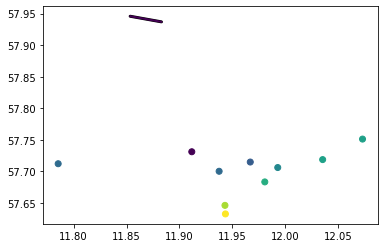

In [393]:
i = 260

plot_map.scatter_line(
    ds_cmls.isel(cml_id=[i, ]).isel(sublink_id=0).rsl.isel(time=0), vmin=0, vmax=1,
)

#closest_gauge.isel(cml_id=0).station_id

ds_gauges_closest = ds_gauge.sel(station_id=closest_gauge.isel(cml_id=i).station_id.values[:10])


#plt.scatter(ds_gauges_closest.lon, ds_gauges_closest.lat)
plt.scatter(ds_gauges_closest.lon, ds_gauges_closest.lat, c=closest_gauge.isel(cml_id=i).distance)

In [107]:
lines = _shapely_lines_from_dataset(ds_cml)
points = _shapely_points_from_dataset(ds_gauge)

In [111]:
%%time 

gauge_distance_per_cml_line = []
for line in lines:
    gauge_distance_per_cml_line.append(line.distance(points))

gauge_distance_per_cml_line[:2]

CPU times: user 7.73 ms, sys: 2.83 ms, total: 10.6 ms
Wall time: 9.95 ms


[array([0.08079134, 0.05352927, 0.09149708, 0.01786174, 0.00307827,
        0.07057734, 0.02935414, 0.08600831, 0.04316719, 0.2062587 ]),
 array([0.09490069, 0.04177139, 0.09504427, 0.04044974, 0.02240334,
        0.08225676, 0.00983541, 0.06144441, 0.05418746, 0.18762799])]

In [116]:
import numpy as np
np.argsort(np.array([0, 2, 1]))

array([0, 2, 1])

In [124]:
cml_to_gauge_distance = xr.DataArray(
    data=gauge_distance_per_cml_line,
    coords={
        'cml_id': ds_cml.cml_id,
        'station_id': ds_gauge.station_id,
    },
)
cml_to_gauge_distance

<xarray.DataArray (cml_id: 364, station_id: 10)>
array([[0.08079134, 0.05352927, 0.09149708, ..., 0.08600831, 0.04316719,
        0.2062587 ],
       [0.09490069, 0.04177139, 0.09504427, ..., 0.06144441, 0.05418746,
        0.18762799],
       [0.06767365, 0.03811334, 0.10979018, ..., 0.07404539, 0.06120292,
        0.19063814],
       ...,
       [0.17447989, 0.18770045, 0.11239935, ..., 0.22244165, 0.10915092,
        0.33857966],
       [0.02394883, 0.07741818, 0.10496934, ..., 0.11652752, 0.06341351,
        0.20012844],
       [0.08935807, 0.04858455, 0.07761342, ..., 0.07550608, 0.02915323,
        0.19943817]])
Coordinates:
  * cml_id      (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
  * station_id  (station_id) object 'Jarn' 'Torp' 'Bergsj' ... 'Lbom' 'Askim'

In [188]:
argsort_index = cml_to_gauge_distance.argsort(axis=1)
argsort_index

<xarray.DataArray (cml_id: 364, station_id: 10)>
array([[4, 3, 6, ..., 7, 2, 9],
       [6, 4, 3, ..., 0, 2, 9],
       [3, 4, 6, ..., 7, 2, 9],
       ...,
       [8, 2, 4, ..., 1, 7, 9],
       [0, 5, 3, ..., 2, 7, 9],
       [4, 6, 3, ..., 5, 0, 9]])
Coordinates:
  * cml_id              (cml_id) int64 10001 10002 10003 ... 10362 10363 10364
  * station_id          (station_id) object 'Jarn' 'Torp' ... 'Lbom' 'Askim'
    station_id_per_cml  (cml_id, station_id) object 'Jarn' 'Torp' ... 'Askim'

In [156]:
cml_to_gauge_distance.station_id.values[argsort_index]

array([['Chalm', 'Torsl', 'Barl', ..., 'Drakeg', 'Bergsj', 'Askim'],
       ['Barl', 'Chalm', 'Torsl', ..., 'Jarn', 'Bergsj', 'Askim'],
       ['Torsl', 'Chalm', 'Barl', ..., 'Drakeg', 'Bergsj', 'Askim'],
       ...,
       ['Lbom', 'Bergsj', 'Chalm', ..., 'Torp', 'Drakeg', 'Askim'],
       ['Jarn', 'Tole', 'Torsl', ..., 'Bergsj', 'Drakeg', 'Askim'],
       ['Chalm', 'Barl', 'Torsl', ..., 'Tole', 'Jarn', 'Askim']],
      dtype=object)

In [161]:
np.sort(cml_to_gauge_distance, axis=1)

array([[0.00307827, 0.01786174, 0.02935414, ..., 0.08600831, 0.09149708,
        0.2062587 ],
       [0.00983541, 0.02240334, 0.04044974, ..., 0.09490069, 0.09504427,
        0.18762799],
       [0.01065352, 0.01809002, 0.02361975, ..., 0.07404539, 0.10979018,
        0.19063814],
       ...,
       [0.10915092, 0.11239935, 0.13793338, ..., 0.18770045, 0.22244165,
        0.33857966],
       [0.02394883, 0.02975716, 0.0449442 , ..., 0.10496934, 0.11652752,
        0.20012844],
       [0.00483043, 0.01792394, 0.02884436, ..., 0.07781248, 0.08935807,
        0.19943817]])

In [311]:
cml_to_gauge_distance.values[0]

array([0.08079134, 0.05352927, 0.09149708, 0.01786174, 0.00307827,
       0.07057734, 0.02935414, 0.08600831, 0.04316719, 0.2062587 ])

In [312]:
cml_to_gauge_distance.station_id.values

array(['Jarn', 'Torp', 'Bergsj', 'Torsl', 'Chalm', 'Tole', 'Barl',
       'Drakeg', 'Lbom', 'Askim'], dtype=object)

In [133]:
cml_to_gauge_distance.station_id.values.

array(['Jarn', 'Torp', 'Bergsj', 'Torsl', 'Chalm', 'Tole', 'Barl',
       'Drakeg', 'Lbom', 'Askim'], dtype=object)

In [132]:
cml_to_gauge_distance['station_per_cml'] = (('cml_id',), cml_to_gauge_distance.station_id.values)

TypeError: Variable 'station_per_cml': Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property.

In [131]:
cml_to_gauge_distance.isel(cml_id=0)

<xarray.DataArray (station_id: 10)>
array([0.08079134, 0.05352927, 0.09149708, 0.01786174, 0.00307827,
       0.07057734, 0.02935414, 0.08600831, 0.04316719, 0.2062587 ])
Coordinates:
    cml_id      int64 10001
  * station_id  (station_id) object 'Jarn' 'Torp' 'Bergsj' ... 'Lbom' 'Askim'

# Download and transform OpenMRG

In [3]:
#get_datasets.download_andersson_2022_OpenMRG()

In [4]:
ds_openmrg = get_datasets.transform_andersson_2022_OpenMRG(
    'OpenMRG.zip',
    'data/andersson_2022_OpenMRG',
    time_start_end=('2015-07-27T00', '2015-07-28T06'),
    restructure_data=True,
)

/Users/chwala-c/code/ragali/notebooks/dev_notebooks/../../ragali/get_datasets.py:309: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'sublink' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds_multindex = ds.assign_coords({'sublink': df_metadata.index})


In [5]:
ds_openmrg

<xarray.Dataset>
Dimensions:       (sublink_id: 2, cml_id: 364, time: 11160)
Coordinates:
  * sublink_id    (sublink_id) <U9 'sublink_1' 'sublink_2'
  * cml_id        (cml_id) int64 10001 10002 10003 10004 ... 10362 10363 10364
  * time          (time) datetime64[ns] 2015-07-27 ... 2015-07-28T06:59:50
    site_0_lat    (cml_id) float64 57.7 57.73 57.69 57.71 ... 57.65 57.66 57.71
    site_0_lon    (cml_id) float64 12.0 11.98 11.97 11.97 ... 12.12 12.03 12.01
    site_1_lat    (cml_id) float64 57.7 57.72 57.69 57.7 ... 57.66 57.63 57.71
    site_1_lon    (cml_id) float64 11.99 11.97 11.98 11.97 ... 12.14 11.97 11.98
    frequency     (sublink_id, cml_id) float64 2.821e+04 3.853e+04 ... 2.926e+04
    polarization  (sublink_id, cml_id) <U1 'v' 'v' 'v' 'v' ... 'v' 'v' 'v' 'v'
    length        (cml_id) float64 691.4 614.6 323.7 ... 4.806e+03 1.412e+03
Data variables:
    tsl           (time, sublink_id, cml_id) float32 1.0 0.0 -5.0 ... 16.0 0.0
    rsl           (time, sublink_id, cml_id) float32 -46.0 -41.3 ... -40.1 -50.4
Attributes: (12/14)
    title:                 OpenMRG-CML
    version:               1.1
    source:                Swedish Meteorological and Hydrological Institute ...
    contact:               hydro.fou@smhi.se, jafet.andersson@smhi.se
    license:               https://creativecommons.org/licenses/by-sa/4.0
    doi:                   https://doi.org/10.5281/zenodo.6673750
    ...                    ...
    institution:           NA
    date:                  NA
    history:               NA
    naming convention:     NA
    license restrictions:  NA
    reference:             NA

# Dev of format checker

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/OpenSenseAction/OS_data_format_conventions/main/netCDF_CML.adoc',
    sep='|',
    skiprows=9,    
)

df = df.drop(columns='Unnamed: 0').drop(0).set_index('Unnamed: 1')
df.index.name = 'Dimensions'

In [8]:
df_required = df[(df.Requisite == ' Required') | (df.Requisite == ' Required*')]
df_required

,Type,Attributes,Requisite,Comments
Dimensions,,,,
time (time),int/float/double,"units = ""seconds since 1970-01-01 00:00:00 UT...",Required,
cml_id (cml_id),string,long_name = “commercial_microwave_link_identi...,Required,cml_id has to be unique across the network
sublink_id (sublink_id),string,long_name = “sublink_identifier”,Required,sublink_id does not have to be unique across ...
site_0_lat (cml_id),float/double,"units = degrees_in_WGS84_projection, long_nam...",Required,
site_0_lon (cml_id),float/double,"units = degrees_in_WGS84_projection, long_nam...",Required,
site_1_lat (cml_id),float/double,"units = degrees_in_WGS84_projection, long_nam...",Required,
site_1_lon (cml_id),float/double,"units = degrees_in_WGS84_projection, long_nam...",Required,
"frequency (cml_id, sublink_id)",float/double,"units = MHz, long_name = “sublink_frequency”",Required,
"tsl (cml_id, sublink_id, time)",float/double,"units = dBm, coordinates = string_with_auxili...",Required*,


In [9]:
for row in df_required.iterrows():
    row


In [10]:
import re
split = re.split(r'\(|\)', row[0])
var_name, dims = split[0], split[1].split(',')
var_name, dims

(' rsl ', ['cml_id', ' sublink_id', ' time'])

In [11]:
OKGREEN = '\033[92m'
WARNING = '\033[93m'
FAIL = '\033[91m'
ENDC = '\033[0m'

ds = ds_openmrg


error_count = 0

print('Checking required variables...')
for row in df_required.iterrows():
    split = re.split(r'\(|\)', row[0])
    var_name, dims = split[0].strip(), tuple(split[1].split(','))
    print(f' {var_name}')
    try:
        ds[var_name]
        if ds[var_name].dims != dims:
            print(f"  {FAIL}dims of variable '{var_name}' are {ds[var_name].dims} but have to be {dims}{ENDC}")
            error_count += 1
        else:
            print(f"  {OKGREEN}OK{ENDC}")
    except:
        print(f"  {FAIL}Required variable '{var_name}' is missing{ENDC}")
        error_count += 1

print()
print(f"{FAIL}{error_count} errors found{ENDC}")



Checking required variables...
 time
  OK
 cml_id
  OK
 sublink_id
  OK
 site_0_lat
  OK
 site_0_lon
  OK
 site_1_lat
  OK
 site_1_lon
  OK
 frequency
  dims of variable 'frequency' are ('sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id')
 tsl
  dims of variable 'tsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')
 rsl
  dims of variable 'rsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')

3 errors found


In [12]:
import format_check

In [13]:
format_check.check_required_cml_metadata(ds_openmrg)

Checking required variables...
 time
  OK
 cml_id
  OK
 sublink_id
  OK
 site_0_lat
  OK
 site_0_lon
  OK
 site_1_lat
  OK
 site_1_lon
  OK
 frequency
  dims of variable 'frequency' are ('sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id')
 tsl
  dims of variable 'tsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')
 rsl
  dims of variable 'rsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')

3 errors found


In [3]:
import xarray as xr
ds_openmrg_cml = xr.open_dataset('../data/openMRG_example.nc')

In [4]:
import format_check
format_check.check_required_cml_metadata(ds_openmrg_cml)

Checking required variables...
 time
  OK
 cml_id
  OK
 sublink_id
  OK
 site_0_lat
  OK
 site_0_lon
  OK
 site_1_lat
  OK
 site_1_lon
  OK
 frequency
  dims of variable 'frequency' are ('sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id')
 tsl
  dims of variable 'tsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')
 rsl
  dims of variable 'rsl' are ('time', 'sublink_id', 'cml_id') but have to be ('cml_id', ' sublink_id', ' time')

3 errors found


# Dev of `plot_ts`

In [5]:
import plot_ts

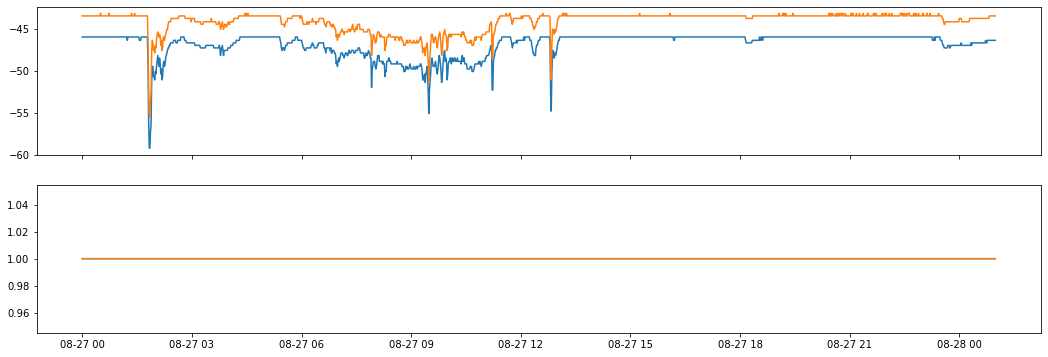

In [6]:
plot_ts.plot_cml_ts(ds_openmrg_cml.isel(cml_id=0), vars_to_plot=['rsl', 'tsl'])

# Dev of `plot_map`

In [4]:
import plot_map

In [6]:
import xarray as xr
ds_openmrg_cml = xr.open_dataset('../data/openMRG_example.nc')

In [8]:
%matplotlib widget

interactive(children=(SelectionSlider(description='t', options=(numpy.datetime64('2015-08-27T00:00:00.00000000…

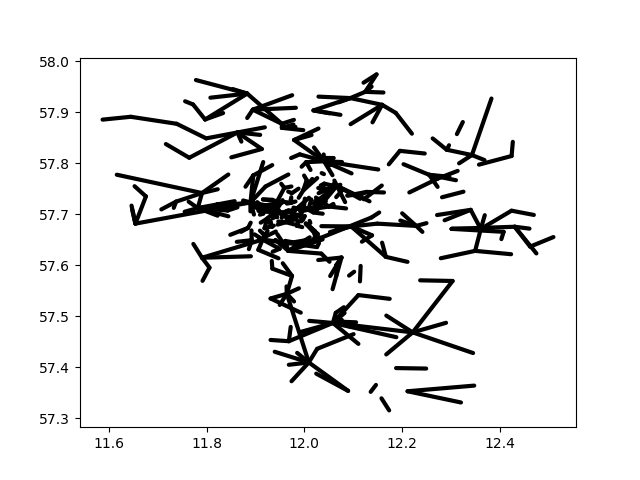

In [9]:
ds = ds_openmrg_cml

ds['trsl'] = ds.tsl - ds.rsl
ds['trsl'] = ds.trsl.interpolate_na(dim='time')
ds['A'] = ds.trsl - ds.trsl.rolling(time=600, center=True).median()

lines = plot_map.scatter_line(
    da=ds.isel(sublink_id=0).A,
    add_time_slider=True,
    vmin=0,
    vmax=30,
    linewidth=2,
    cmap='magma',
)

## Open smaller dataset for which there is also a small radar NetCDF

In [10]:
ds_cmls = xr.open_dataset('../data/openMRG_example.nc')
ds_cmls['trsl'] = ds_cmls.tsl - ds_cmls.rsl
ds_cmls['trsl'] = ds_cmls.trsl.interpolate_na(dim='time')
ds_cmls['A'] = ds_cmls.trsl - ds_cmls.trsl.rolling(time=60, center=True).median()

In [29]:
ds_radar = xr.open_dataset('../data/openMRG_example_rad.nc')
ds_radar

<xarray.Dataset>
Dimensions:   (time: 19, x: 37, y: 48)
Coordinates:
  * time      (time) datetime64[ns] 2015-08-27T01:00:00 ... 2015-08-27T02:30:00
  * x         (x) float64 -1.542e+05 -1.522e+05 ... -8.42e+04 -8.22e+04
  * y         (y) float64 -3.413e+06 -3.415e+06 ... -3.505e+06 -3.507e+06
Data variables:
    crs       int32 ...
    lat       (y, x) float32 ...
    lon       (y, x) float32 ...
    rainfall  (time, y, x) float64 ...
Attributes:
    source:       Swedish Meteorological and Hydrological Institute (SMHI), H...
    contact:      hydro.fou@smhi.se, remco.vandebeek@smhi.se
    title:        OpenMRG-Radar
    license:      https://creativecommons.org/licenses/by-sa/4.0
    version:      1.1
    doi:          https://doi.org/10.5281/zenodo.6673750
    proj_string:  +proj=stere +lat_ts=60 +ellps=bessel +lon_0=14 +lat_0=90
    comment:      Created by Remco van de Beek, Victor Näslund and Johan Thur...

In [79]:
import grid_intersection

intersect_weights = grid_intersection.calc_sparse_intersect_weights_for_several_cmls(
    ds_cmls=ds_openmrg_cml,
    x_grid=ds_radar.lon.T.values,
    y_grid=ds_radar.lat.T.values,
    #grid_point_location='lower_left',
    grid_point_location='center',
)

In [80]:
intersect_weights

Format,coo
Data Type,float64
Shape,"(364, 37, 48)"
nnz,386
Density,0.0005970943470943471
Read-only,True
Size,12.1K
Storage ratio,0.0


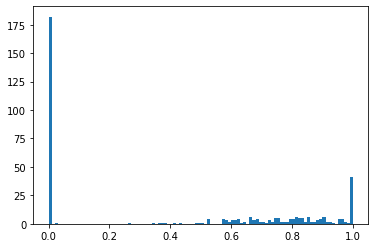

In [82]:
intersect_weights.sum(dim=['x', 'y']).plot.hist(bins=100);

In [83]:
%matplotlib inline

3719.42


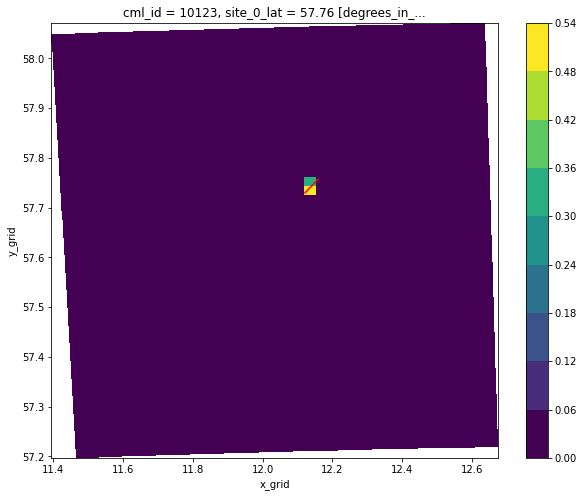

In [84]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
i = 122

intersect_weights.isel(cml_id=i).plot(x='x_grid', y='y_grid', levels=10)
ds_i = ds_cmls.isel(cml_id=i)
ax.plot((ds_i.site_0_lon, ds_i.site_1_lon), (ds_i.site_0_lat, ds_i.site_1_lat), 'r')
print(ds_i.length.values)

In [85]:
import numpy as np
np.unique(intersect_weights.isel(cml_id=i).data.todense())

array([0.        , 0.31589609, 0.51823638])

In [223]:
intersec_weights.shape

(364, 37, 48)

In [224]:
ds_radar.lon.T.shape

(37, 48)

In [225]:
ds_radar.rainfall.transpose('time', 'x', 'y').shape

(19, 37, 48)

In [86]:
intersect_weights

Format,coo
Data Type,float64
Shape,"(364, 37, 48)"
nnz,386
Density,0.0005970943470943471
Read-only,True
Size,12.1K
Storage ratio,0.0


In [87]:
intersect_weights

Format,coo
Data Type,float64
Shape,"(364, 37, 48)"
nnz,386
Density,0.0005970943470943471
Read-only,True
Size,12.1K
Storage ratio,0.0


In [88]:
radar_along_cml = grid_intersection.get_grid_time_series_at_intersections(
    grid_data=ds_radar.rainfall.transpose('time', 'x', 'y').values,
    intersect_weights=intersect_weights,
)
radar_along_cml['time'] = ds_radar.time
radar_along_cml['site_0_lat'] = intersect_weights.site_0_lat
radar_along_cml['site_0_lon'] = intersect_weights.site_0_lon
radar_along_cml['site_1_lat'] = intersect_weights.site_1_lat
radar_along_cml['site_1_lon'] = intersect_weights.site_1_lon

In [89]:
%matplotlib inline

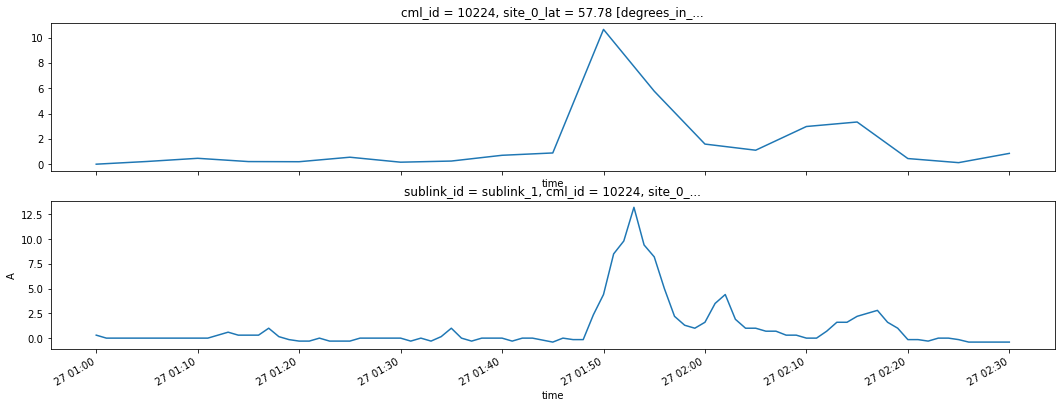

In [90]:
fig, axs = plt.subplots(2, 1, figsize=(18, 6), sharex=True)
i = 223
radar_along_cml.isel(cml_id=i).plot(ax=axs[0])
ds_cmls.isel(cml_id=i, sublink_id=0).sel(time=slice(radar_along_cml.time.min(), radar_along_cml.time.max())).A.plot(zorder=-3, ax=axs[1]);

In [91]:
%matplotlib widget

interactive(children=(SelectionSlider(description='t', options=(numpy.datetime64('2015-08-27T01:00:00.00000000…

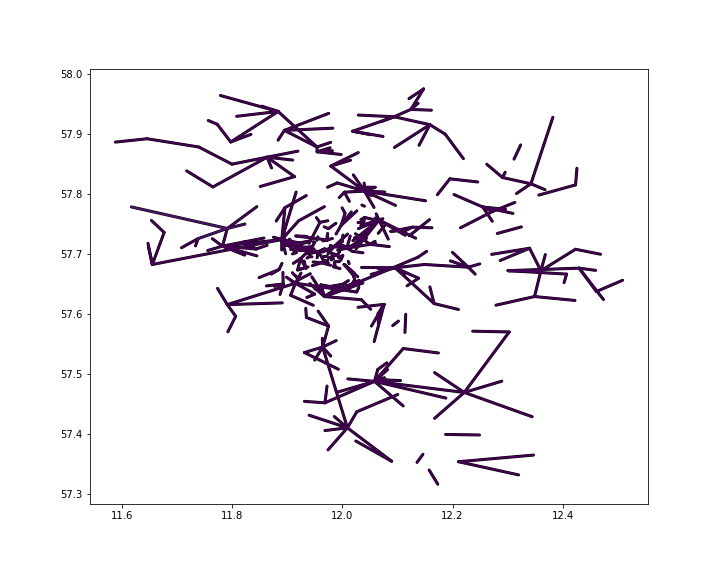

In [103]:
fig, ax = plt.subplots(figsize=(10, 8));
plot_map.scatter_line(
    da=radar_along_cml,
    add_time_slider=True,
    ax=ax,
    vmin=0,
    vmax=50,
);